In [1]:
# RERUN AT HOME
import glob

In [2]:
# RERUN AT HOME
path = "/Users/jasur/desktop/FER13/" # use your path, all images

In [3]:
# RERUN AT HOME
angry_images = glob.glob(path + 'train/angry/*', recursive=True)
fear_images = glob.glob(path + 'train/fear/*', recursive=True)
happy_images = glob.glob(path + 'train/happy/*', recursive=True)
neutral_images = glob.glob(path + 'train/neutral/*', recursive=True)
surprise_images = glob.glob(path + 'train/surprise/*', recursive=True)
sad_images = glob.glob(path + 'train/sad/*', recursive=True)

In [4]:
train_images = angry_images + fear_images + happy_images + neutral_images + surprise_images + sad_images
print("Number of images: ", len(train_images))

Number of images:  23765


In [5]:
# RERUN AT HOME
angry_images = glob.glob(path + 'test/angry/*', recursive=True)
fear_images = glob.glob(path + 'test/fear/*', recursive=True)
happy_images = glob.glob(path + 'test/happy/*', recursive=True)
neutral_images = glob.glob(path + 'test/neutral/*', recursive=True)
surprise_images = glob.glob(path + 'test/surprise/*', recursive=True)
sad_images = glob.glob(path + 'test/sad/*', recursive=True)

In [6]:
test_images = angry_images + fear_images + happy_images + neutral_images + surprise_images + sad_images
print("Number of images: ", len(test_images))

Number of images:  5931


In [7]:
import numpy as np

np.random.shuffle(train_images)
np.random.shuffle(test_images)
train_images = train_images[:int(len(train_images)*0.8)]
val_images = train_images[int(len(train_images)*0.8):]
print("Number of train images: ", len(train_images))
print("Number of val images: ", len(val_images))
print("Number of test images: ", len(test_images))

Number of train images:  19012
Number of val images:  3803
Number of test images:  5931


In [8]:
from PIL import Image
import os
import numpy as np
import pickle
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

def preprocess(image_paths, cat, train = False,
               label_encoder = None, target_size = (224, 224)):
    images, labels = [], []

    for path in image_paths:
        img = Image.open(path).convert('RGB')
        img = img.resize(target_size)
        img_array = np.array(img) / 255.0  
        images.append(img_array)

    for path in image_paths:
        label = os.path.basename(os.path.dirname(path))
        labels.append(label)
    if train:
        label_encoder = LabelEncoder()
        encoded_labels = label_encoder.fit_transform(labels)
    else:
        encoded_labels = label_encoder.transform(labels)

    onehot_encoder = OneHotEncoder(sparse=False)
    encoded_labels = encoded_labels.reshape(len(encoded_labels), 1)
    onehot_labels = onehot_encoder.fit_transform(encoded_labels)

    images = np.array([img.reshape(target_size[0], target_size[1], 3) for img in images])
    labels = np.array(onehot_labels)

    dataset = tf.data.Dataset.from_tensor_slices((images, labels))

    batch_size = 32
    shuffle_buffer_size = len(images) 

    dataset = dataset.shuffle(buffer_size=shuffle_buffer_size)
    dataset = dataset.batch(batch_size)

    save_path = "/Users/jasur/desktop/FER13/Data_Even_More_.np_arrays/"
    os.makedirs(save_path, exist_ok=True)

    np.save(os.path.join(save_path, 'X_' + cat + '.npy'), images)
    np.save(os.path.join(save_path, 'y_' + cat + '.npy'), labels)

    return dataset, label_encoder


train_dataset, label_encoder = preprocess(train_images, 'train', train=True)
val_dataset, _ = preprocess(val_images, 'val', label_encoder=label_encoder)
test_dataset, _ = preprocess(test_images, 'test', label_encoder=label_encoder)

/Users/jasur/Library/Python/3.9/lib/python/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/jasur/Library/Python/3.9/lib/python/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/jasur/Library/Python/3.9/lib/python/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [5]:
from PIL import Image
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras

save_path = "/Users/jasur/desktop/FER13/Data_Even_More_.np_arrays/"

images = np.load(os.path.join(save_path, 'X_train.npy'))
labels = np.load(os.path.join(save_path, 'y_train.npy'))
train_dataset = tf.data.Dataset.from_tensor_slices((images, labels))

batch_size = 32
shuffle_buffer_size = len(images) 

train_dataset = train_dataset.shuffle(buffer_size=shuffle_buffer_size)
train_dataset = train_dataset.batch(batch_size)

In [6]:
images = np.load(os.path.join(save_path, 'X_val.npy'))
labels = np.load(os.path.join(save_path, 'y_val.npy'))
val_dataset = tf.data.Dataset.from_tensor_slices((images, labels))

shuffle_buffer_size = len(images) 

val_dataset = val_dataset.shuffle(buffer_size=shuffle_buffer_size)
val_dataset = val_dataset.batch(batch_size)

In [7]:
images = np.load(os.path.join(save_path, 'X_test.npy'))
labels = np.load(os.path.join(save_path, 'y_test.npy'))
test_dataset = tf.data.Dataset.from_tensor_slices((images, labels))

shuffle_buffer_size = len(images) 

test_dataset = test_dataset.shuffle(buffer_size=shuffle_buffer_size)
test_dataset = test_dataset.batch(batch_size)

In [6]:
from tensorflow import keras
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout,\
BatchNormalization, Activation, SpatialDropout2D, GlobalAveragePooling2D
from keras.optimizers import Adam, SGD
from keras.models import Sequential

model = Sequential()

model.add(Conv2D(32, (3, 3), padding='same', input_shape=(224, 224, 3)))
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(SpatialDropout2D(0.2))

model.add(Conv2D(128, (3, 3), padding='same', input_shape=(224, 224, 3)))
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(SpatialDropout2D(0.2))

model.add(Flatten())

model.add(Dense(256, activation='relu'))
model.add(Dropout(0.35))
model.add(Dense(6, activation='softmax'))

model.compile(optimizer=Adam(learning_rate=0.0001), 
                  loss='categorical_crossentropy', 
                  metrics=['accuracy'])
model.load_weights("/Users/jasur/desktop/saved_weights/CustomNet.h5")


In [7]:
from keras.callbacks import ModelCheckpoint, EarlyStopping

chk_path = 'CustomNet.h5'

checkpoint = ModelCheckpoint(filepath=chk_path,
                             save_best_only=True,
                             verbose=1,
                             moniter='val_accuracy')

earlystop = EarlyStopping(monitor='val_accuracy',  
                          patience=3, 
                          verbose=1, 
                          restore_best_weights=True)

callbacks = [checkpoint, earlystop]

In [8]:
# ADD MORE OF THESE BLOCKS TO TRAIN MORE IF YOU THINK IT'S A PROMISING MODEL
model_sum = model.fit(train_dataset,
                      validation_data=val_dataset,
                      epochs=3, 
                      callbacks=callbacks)

Epoch 1/3
446/446 [==============================] - ETA: 0s - loss: 1.7598 - accuracy: 0.2187
Epoch 1: val_loss improved from inf to 1.72741, saving model to CustomNet.h5


/Users/jasur/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


446/446 [==============================] - 2504s 6s/step - loss: 1.7598 - accuracy: 0.2187 - val_loss: 1.7274 - val_accuracy: 0.3051
Epoch 2/3
446/446 [==============================] - ETA: 0s - loss: 1.7204 - accuracy: 0.2983
Epoch 2: val_loss improved from 1.72741 to 1.69936, saving model to CustomNet.h5
446/446 [==============================] - 2737s 6s/step - loss: 1.7204 - accuracy: 0.2983 - val_loss: 1.6994 - val_accuracy: 0.3072
Epoch 3/3
446/446 [==============================] - ETA: 0s - loss: 1.6878 - accuracy: 0.3056
Epoch 3: val_loss improved from 1.69936 to 1.68898, saving model to CustomNet.h5
446/446 [==============================] - 2527s 6s/step - loss: 1.6878 - accuracy: 0.3056 - val_loss: 1.6890 - val_accuracy: 0.3116


In [9]:
# ADD MORE OF THESE BLOCKS TO TRAIN MORE IF YOU THINK IT'S A PROMISING MODEL
model_sum = model.fit(train_dataset,
                      validation_data=val_dataset,
                      epochs=10, 
                      callbacks=callbacks)

Epoch 1/10
446/446 [==============================] - ETA: 0s - loss: 1.6520 - accuracy: 0.3138
Epoch 1: val_loss improved from 1.68898 to 1.66044, saving model to CustomNet.h5
446/446 [==============================] - 2833s 6s/step - loss: 1.6520 - accuracy: 0.3138 - val_loss: 1.6604 - val_accuracy: 0.3181
Epoch 2/10
446/446 [==============================] - ETA: 0s - loss: 1.6159 - accuracy: 0.3267
Epoch 2: val_loss did not improve from 1.66044
446/446 [==============================] - 2847s 6s/step - loss: 1.6159 - accuracy: 0.3267 - val_loss: 1.6714 - val_accuracy: 0.3164
Epoch 3/10
446/446 [==============================] - ETA: 0s - loss: 1.5804 - accuracy: 0.3373
Epoch 3: val_loss improved from 1.66044 to 1.65582, saving model to CustomNet.h5
446/446 [==============================] - 2864s 6s/step - loss: 1.5804 - accuracy: 0.3373 - val_loss: 1.6558 - val_accuracy: 0.3194
Epoch 4/10
446/446 [==============================] - ETA: 0s - loss: 1.5408 - accuracy: 0.3492
Epoch 4:

In [10]:
scores = model.evaluate(test_dataset, verbose=1)

print('Test accuracy:', scores[1])
print('Test loss:', scores[0])

149/149 [==============================] - 240s 2s/step - loss: 1.6836 - accuracy: 0.3354
Test accuracy: 0.3353671431541443
Test loss: 1.6835956573486328


In [13]:
from matplotlib import pyplot as plt

plt.plot(list(range(1, 4)), model_sum.history["loss"])
plt.plot(list(range(1, 4)), model_sum.history["val_loss"])
plt.title("Model loss on validation and training sets")
plt.legend(["Train", "Validation"])
plt.xlabel("Epochs")
plt.ylabel("Cross Entropy Loss")
plt.show()

In [ ]:
plt.plot(list(range(1, 4)), model_sum.history["accuracy"])
plt.plot(list(range(1, 4)), model_sum.history["val_accuracy"])
plt.title("Model accuracy on validation and training sets")
plt.legend(["Train", "Validation"])
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.show()

In [2]:
from keras.applications.vgg16 import VGG16
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, \
    BatchNormalization, Activation, SpatialDropout2D, GlobalAveragePooling2D
from keras.optimizers import Adam, SGD
from keras.models import Sequential, Model


model_1 = VGG16(weights = 'imagenet', input_shape=(224, 224, 3), include_top = False)

model_1.trainable = False


model_2 = Sequential()

model_2.add(Conv2D(128, (5, 5), padding='same', input_shape=model_1.output_shape[1:]))
model_2.add(Conv2D(256, kernel_size=(3, 3), activation='relu', padding='same'))
model_2.add(BatchNormalization())
model_2.add(MaxPooling2D(pool_size=(2, 2)))
model_2.add(SpatialDropout2D(0.25))

model_2.add(Flatten())

model_2.add(Dense(64, activation='relu'))
model_2.add(Dense(256, activation='relu'))
model_2.add(Dense(6, activation='softmax'))

model = Model(inputs=model_1.input, outputs=model_2(model_1.output))

for layer in model.layers:
    layer.trainable = True
    
model.compile(optimizer=Adam(learning_rate=0.0001), 
                  loss='categorical_crossentropy', 
                  metrics=['accuracy'])

model.load_weights("/Users/jasur/desktop/CustomVGG.h5")

In [3]:
from keras.callbacks import ModelCheckpoint, EarlyStopping

chk_path = 'CustomVGG.h5'

checkpoint = ModelCheckpoint(filepath=chk_path,
                             save_best_only=True,
                             verbose=1,
                             moniter='val_accuracy')

earlystop = EarlyStopping(monitor='val_accuracy',  
                          patience=3, 
                          verbose=1, 
                          restore_best_weights=True)

callbacks = [checkpoint, earlystop]

In [15]:
# VGG epoch 1
# ADD MORE OF THESE BLOCKS TO TRAIN MORE IF YOU THINK IT'S A PROMISING MODEL
num_epochs = 1
model_sum = model.fit(train_dataset,
                      validation_data=val_dataset,
                      epochs=num_epochs, 
                      callbacks=callbacks)

446/446 [==============================] - ETA: 0s - loss: 1.0159 - accuracy: 0.6111 
Epoch 1: val_loss improved from inf to 1.24042, saving model to CustomVGG.h5


/Users/jasur/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


446/446 [==============================] - 8860s 20s/step - loss: 1.0159 - accuracy: 0.6111 - val_loss: 1.2404 - val_accuracy: 0.5601


In [16]:
scores = model.evaluate(test_dataset, verbose=1)

print('Test accuracy:', scores[1])
print('Test loss:', scores[0])

149/149 [==============================] - 693s 5s/step - loss: 1.2294 - accuracy: 0.5424
Test accuracy: 0.5423942804336548
Test loss: 1.2293654680252075


In [17]:
# VGG epoch 2
# ADD MORE OF THESE BLOCKS TO TRAIN MORE IF WE THINK IT'S A PROMISING MODEL
num_epochs = 1
model_sum = model.fit(train_dataset,
                      validation_data=val_dataset,
                      epochs=num_epochs, 
                      callbacks=callbacks)

446/446 [==============================] - ETA: 0s - loss: 0.9302 - accuracy: 0.6491 
Epoch 1: val_loss improved from 1.24042 to 1.01711, saving model to CustomVGG.h5
446/446 [==============================] - 7457s 17s/step - loss: 0.9302 - accuracy: 0.6491 - val_loss: 1.0171 - val_accuracy: 0.6133


In [18]:
# VGG epoch 3
# ADD MORE OF THESE BLOCKS TO TRAIN MORE IF WE THINK IT'S A PROMISING MODEL
num_epochs = 1
model_sum = model.fit(train_dataset,
                      validation_data=val_dataset,
                      epochs=num_epochs, 
                      callbacks=callbacks)

446/446 [==============================] - ETA: 0s - loss: 0.8479 - accuracy: 0.6816 
Epoch 1: val_loss improved from 1.01711 to 0.97175, saving model to CustomVGG.h5
446/446 [==============================] - 9165s 21s/step - loss: 0.8479 - accuracy: 0.6816 - val_loss: 0.9717 - val_accuracy: 0.6335


In [20]:
# VGG epoch 4
# ADD MORE OF THESE BLOCKS TO TRAIN MORE IF WE THINK IT'S A PROMISING MODEL
num_epochs = 1
model_sum = model.fit(train_dataset,
                      validation_data=val_dataset,
                      epochs=num_epochs, 
                      callbacks=callbacks)

446/446 [==============================] - ETA: 0s - loss: 0.7637 - accuracy: 0.7157 
Epoch 1: val_loss did not improve from 0.97175
446/446 [==============================] - 8949s 20s/step - loss: 0.7637 - accuracy: 0.7157 - val_loss: 1.0545 - val_accuracy: 0.6272


In [12]:
scores = model.evaluate(test_dataset, verbose=1)

print('Test accuracy:', scores[1])
print('Test loss:', scores[0])

In [22]:
# VGG epoch 5
# ADD MORE OF THESE BLOCKS TO TRAIN MORE IF WE THINK IT'S A PROMISING MODEL
num_epochs = 1
model_sum = model.fit(train_dataset,
                      validation_data=val_dataset,
                      epochs=num_epochs, 
                      callbacks=callbacks)

446/446 [==============================] - ETA: 0s - loss: 0.6605 - accuracy: 0.7548 
Epoch 1: val_loss did not improve from 0.97175
446/446 [==============================] - 8859s 20s/step - loss: 0.6605 - accuracy: 0.7548 - val_loss: 1.0126 - val_accuracy: 0.6489


In [23]:
# VGG epoch 5 to 9
# ADD MORE OF THESE BLOCKS TO TRAIN MORE IF WE THINK IT'S A PROMISING MODEL
num_epochs = 4
model_sum = model.fit(train_dataset,
                      validation_data=val_dataset,
                      epochs=num_epochs, 
                      callbacks=callbacks)

Epoch 1/4
446/446 [==============================] - ETA: 0s - loss: 0.5460 - accuracy: 0.8030 
Epoch 1: val_loss did not improve from 0.97175
446/446 [==============================] - 9021s 20s/step - loss: 0.5460 - accuracy: 0.8030 - val_loss: 1.0445 - val_accuracy: 0.6440
Epoch 2/4
446/446 [==============================] - ETA: 0s - loss: 0.4359 - accuracy: 0.8395 
Epoch 2: val_loss did not improve from 0.97175
446/446 [==============================] - 9098s 20s/step - loss: 0.4359 - accuracy: 0.8395 - val_loss: 1.2359 - val_accuracy: 0.6120
Epoch 3/4
446/446 [==============================] - ETA: 0s - loss: 0.3323 - accuracy: 0.8824 
Epoch 3: val_loss did not improve from 0.97175
446/446 [==============================] - 9172s 21s/step - loss: 0.3323 - accuracy: 0.8824 - val_loss: 1.2123 - val_accuracy: 0.6377
Epoch 4/4
446/446 [==============================] - ETA: 0s - loss: 0.2450 - accuracy: 0.9108 
Epoch 4: val_loss did not improve from 0.97175
Restoring model weights fr

In [7]:
# VGG epoch 1 with Even_More_Data
# ADD MORE OF THESE BLOCKS TO TRAIN MORE IF WE THINK IT'S A PROMISING MODEL
num_epochs = 1
model_sum = model.fit(train_dataset,
                      validation_data=val_dataset,
                      epochs=num_epochs, 
                      callbacks=callbacks)

595/595 [==============================] - ETA: 0s - loss: 1.0169 - accuracy: 0.6111 
Epoch 1: val_loss improved from inf to 0.91395, saving model to CustomVGG.h5


/Users/jasur/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


595/595 [==============================] - 8805s 15s/step - loss: 1.0169 - accuracy: 0.6111 - val_loss: 0.9140 - val_accuracy: 0.6553


In [8]:
# VGG epoch 2 to 5 with Even_More_Data
# ADD MORE OF THESE BLOCKS TO TRAIN MORE IF WE THINK IT'S A PROMISING MODEL
num_epochs = 4
model_sum = model.fit(train_dataset,
                      validation_data=val_dataset,
                      epochs=num_epochs, 
                      callbacks=callbacks)

Epoch 1/4
595/595 [==============================] - ETA: 0s - loss: 0.9247 - accuracy: 0.6489 
Epoch 1: val_loss improved from 0.91395 to 0.85973, saving model to CustomVGG.h5
595/595 [==============================] - 8937s 15s/step - loss: 0.9247 - accuracy: 0.6489 - val_loss: 0.8597 - val_accuracy: 0.6863
Epoch 2/4
595/595 [==============================] - ETA: 0s - loss: 0.8361 - accuracy: 0.6840 
Epoch 2: val_loss improved from 0.85973 to 0.82304, saving model to CustomVGG.h5
595/595 [==============================] - 8852s 15s/step - loss: 0.8361 - accuracy: 0.6840 - val_loss: 0.8230 - val_accuracy: 0.6897
Epoch 3/4
595/595 [==============================] - ETA: 0s - loss: 0.7614 - accuracy: 0.7184 
Epoch 3: val_loss improved from 0.82304 to 0.68986, saving model to CustomVGG.h5
595/595 [==============================] - 8881s 15s/step - loss: 0.7614 - accuracy: 0.7184 - val_loss: 0.6899 - val_accuracy: 0.7486
Epoch 4/4
595/595 [==============================] - ETA: 0s - loss

In [9]:
# Test Accuracy on VGG with Even_More_Data
scores = model.evaluate(test_dataset, verbose=1)

print('Test accuracy:', scores[1])
print('Test loss:', scores[0])

186/186 [==============================] - 790s 4s/step - loss: 1.0556 - accuracy: 0.6321
Test accuracy: 0.6321024894714355
Test loss: 1.0555546283721924


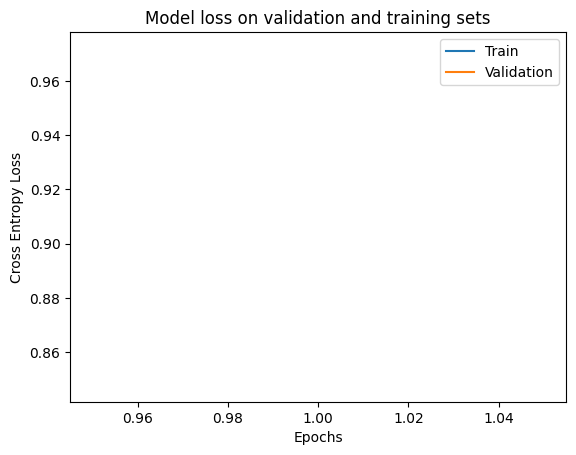

In [19]:
plt.plot(list(range(1, num_epochs + 1)), model_sum.history["loss"])
plt.plot(list(range(1, num_epochs + 1)), model_sum.history["val_loss"])
plt.title("Model loss on validation and training sets")
plt.legend(["Train", "Validation"])
plt.xlabel("Epochs")
plt.ylabel("Cross Entropy Loss")
plt.show()

In [ ]:
plt.plot(list(range(1, num_epochs + 1)), model_sum.history["accuracy"])
plt.plot(list(range(1, num_epochs + 1)), model_sum.history["val_accuracy"])
plt.title("Model accuracy on validation and training sets")
plt.legend(["Train", "Validation"])
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.show()

In [ ]:
%pwd